In [291]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.inspection import permutation_importance
from nltools.stats import isc, circle_shift
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, Lasso, RidgeCV, Ridge, LinearRegression, RidgeClassifierCV, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, SVR, LinearSVR
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import validation_curve, cross_val_score
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV, StratifiedShuffleSplit, GroupKFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, permutation_test_score
from sklearn.pipeline import Pipeline
import scipy.spatial 
from nltools.stats import _calc_pvalue, fisher_r_to_z, fisher_z_to_r, fdr
from nltools.utils import check_random_state
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.base import clone
from sklearn.model_selection import RepeatedKFold
from scipy import spatial
from tqdm import tqdm, trange

# from feat.plotting import animate_face
# from feat import Fex
# from feat.plotting import draw_lineface, draw_muscles, draw_vectorfield, plot_face, predict
# pd.set_option('Max_rows', 10)
MAX_INT = np.iinfo(np.int32).max
sns.set_theme(style='white')

fpath = '/Users/chenyuchieh/Desktop/SED_facial'

In [292]:
sub = pd.read_csv((os.path.join(fpath, 'Data', 'SED', 'SED_subject list.csv')))

In [293]:
# Drop the subject without facial data and grouping
sub.drop(sub.index[sub['dyads'] == 'N'], inplace=True)
sub

,ID,group,att,facial,dyads,note
0,SED001,SS001,S,Y,Y,NaN
1,SED002,SS001,S,Y,Y,NaN
2,SED003,SS002,S,Y,Y,NaN
3,SED004,SS002,S,Y,Y,NaN
4,SED005,SS003,S,Y,Y,NaN
5,SED006,SS003,S,Y,Y,NaN
6,SED007,SS004,S,Y,Y,NaN
7,SED008,SS004,S,Y,Y,NaN
8,SED009,SS005,S,Y,Y,NaN
9,SED010,SS005,S,Y,Y,NaN


In [294]:
sub_paths = sorted(glob.glob(os.path.join(fpath, 'Data','SED', 'emotion_interpo_fps1', '*.csv')))
sub_paths

['/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/SED001.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/SED002.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/SED003.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/SED004.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/SED005.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/SED006.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/SED007.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/SED008.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/SED009.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/SED010.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/SED011.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/SED012.csv',
 '/U

In [295]:
sub_list = []
for i in sub_paths:
    sub_id = i.split('/')[-1].split('.')[0]
    if sub_id in list(sub['ID']):
#         print(sub_id)
        sub_list.append(sub_id)
sub_list

['SED001',
 'SED002',
 'SED003',
 'SED004',
 'SED005',
 'SED006',
 'SED007',
 'SED008',
 'SED009',
 'SED010',
 'SED011',
 'SED012',
 'SED013',
 'SED014',
 'SED015',
 'SED016',
 'SED017',
 'SED018',
 'SED019',
 'SED020',
 'SED021',
 'SED022',
 'SED023',
 'SED024',
 'SED025',
 'SED026',
 'SED027',
 'SED028',
 'SED029',
 'SED030',
 'SED035',
 'SED036',
 'SED037',
 'SED038',
 'SED039',
 'SED040',
 'SED043',
 'SED044',
 'SED045',
 'SED046',
 'SED049',
 'SED050',
 'SED059',
 'SED060']

In [296]:
group_list = []
for i in sub_paths:
    sub_id = i.split('/')[-1].split('.')[0]
    if sub_id in sub_list:
        group_id = sub[sub['ID'] == str(sub_id)]['group'].values[0]
        if group_id not in group_list:
            group_list.append(group_id)
group_list

['SS001',
 'SS002',
 'SS003',
 'SS004',
 'SS005',
 'SS006',
 'SS007',
 'SS008',
 'SS009',
 'SS010',
 'SS011',
 'SS012',
 'SS013',
 'SS014',
 'SS015',
 'SS018',
 'SS019',
 'SS020',
 'SS022',
 'SS023',
 'SS025',
 'SS030']

# Real Dyad (RD) ISC 

In [297]:
# sub[sub['ID'] == str('SED001')]

In [298]:
dyad = sub.groupby('group')
dyad.groups

{'SS001': [0, 1], 'SS002': [2, 3], 'SS003': [4, 5], 'SS004': [6, 7], 'SS005': [8, 9], 'SS006': [10, 11], 'SS007': [12, 13], 'SS008': [14, 15], 'SS009': [16, 17], 'SS010': [18, 19], 'SS011': [20, 21], 'SS012': [22, 23], 'SS013': [24, 25], 'SS014': [26, 27], 'SS015': [28, 29], 'SS018': [34, 35], 'SS019': [36, 37], 'SS020': [38, 39], 'SS022': [42, 43], 'SS023': [44, 45], 'SS025': [48, 49], 'SS030': [56, 57]}

In [299]:
# dyad.get_group("SS001")

## Anger 

In [300]:
RD_anger = []
for i in tqdm(group_list):
    subjects = dyad.get_group(str(i))
#     print(subjects)
    sub1 = subjects.iloc[0,0]
    sub2 = subjects.iloc[1,0]
#     print(sub1)
#     print(sub2)
    emotion_tseries_list = []
    emotion_tseries1 = pd.read_csv('/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/'+sub1+'.csv').drop("Unnamed: 0",axis=1)
    emotion_tseries2 = pd.read_csv('/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/'+sub2+'.csv').drop("Unnamed: 0",axis=1)
    emotion_tseries_list.append(emotion_tseries1)
    emotion_tseries_list.append(emotion_tseries2)
    df = pd.DataFrame()
    for j in range(len(emotion_tseries_list)):
         df = df.append(emotion_tseries_list[j]['anger'])
#     print(df)
    isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
    RD_anger.append(isc)
RD_anger = pd.DataFrame(RD_anger)

  0%|          | 0/22 [00:00<?, ?it/s]<ipython-input-300-80372d28d82e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['anger'])
<ipython-input-300-80372d28d82e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['anger'])
<ipython-input-300-80372d28d82e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['anger'])
<ipython-input-300-80372d28d82e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['anger'])
<ipython-input-300-80372d28d82e>:16: FutureWarning: The frame.append method is

100%|██████████| 22/22 [00:00<00:00, 76.80it/s]


In [301]:
# emotion_tseries_list[1]['anger']

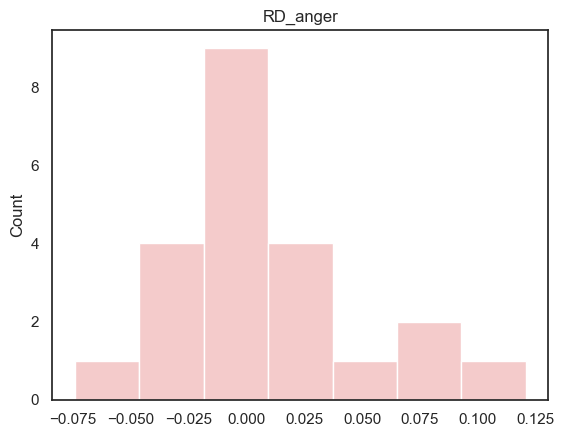

In [302]:
sns.histplot(data=RD_anger, legend = False, palette = ['#ea9999']).set_title('RD_anger')
plt.savefig(os.path.join(fpath,'Result','ISC_RD_anger.png'), dpi=300)

## Disgust

In [303]:
RD_disgust = []
for i in tqdm(group_list):
    subjects = dyad.get_group(str(i))
#     print(subjects)
    sub1 = subjects.iloc[0,0]
    sub2 = subjects.iloc[1,0]
#     print(sub1)
#     print(sub2)
    emotion_tseries_list = []
    emotion_tseries1 = pd.read_csv('/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/'+sub1+'.csv').drop("Unnamed: 0",axis=1)
    emotion_tseries2 = pd.read_csv('/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/'+sub2+'.csv').drop("Unnamed: 0",axis=1)
    emotion_tseries_list.append(emotion_tseries1)
    emotion_tseries_list.append(emotion_tseries2)
    df = pd.DataFrame()
    for j in range(len(emotion_tseries_list)):
         df = df.append(emotion_tseries_list[j]['disgust'])
#     print(df)
    isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
    RD_disgust.append(isc)
RD_disgust = pd.DataFrame(RD_disgust)

  0%|          | 0/22 [00:00<?, ?it/s]<ipython-input-303-a21f2bccabc0>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['disgust'])
<ipython-input-303-a21f2bccabc0>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['disgust'])
<ipython-input-303-a21f2bccabc0>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['disgust'])
<ipython-input-303-a21f2bccabc0>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['disgust'])
<ipython-input-303-a21f2bccabc0>:16: FutureWarning: The frame.append m

 91%|█████████ | 20/22 [00:00<00:00, 94.79it/s]<ipython-input-303-a21f2bccabc0>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['disgust'])
<ipython-input-303-a21f2bccabc0>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['disgust'])
<ipython-input-303-a21f2bccabc0>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['disgust'])
<ipython-input-303-a21f2bccabc0>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['disgust'])
100%|██████████| 22/22 [00:00<00:00, 91.91it/s]


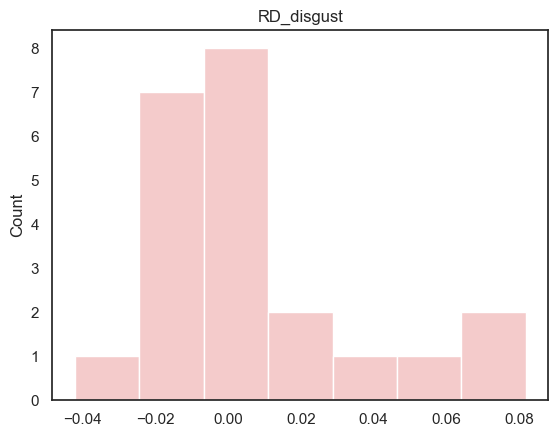

In [304]:
sns.histplot(data=RD_disgust, legend = False, palette = ['#ea9999']).set_title('RD_disgust')
plt.savefig(os.path.join(fpath,'Result','ISC_RD_disgust.png'), dpi=300)

## Fear

In [305]:
RD_fear = []
for i in tqdm(group_list):
    subjects = dyad.get_group(str(i))
#     print(subjects)
    sub1 = subjects.iloc[0,0]
    sub2 = subjects.iloc[1,0]
#     print(sub1)
#     print(sub2)
    emotion_tseries_list = []
    emotion_tseries1 = pd.read_csv('/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/'+sub1+'.csv').drop("Unnamed: 0",axis=1)
    emotion_tseries2 = pd.read_csv('/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/'+sub2+'.csv').drop("Unnamed: 0",axis=1)
    emotion_tseries_list.append(emotion_tseries1)
    emotion_tseries_list.append(emotion_tseries2)
    df = pd.DataFrame()
    for j in range(len(emotion_tseries_list)):
         df = df.append(emotion_tseries_list[j]['fear'])
#     print(df)
    isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
    RD_fear.append(isc)
RD_fear = pd.DataFrame(RD_fear)

  0%|          | 0/22 [00:00<?, ?it/s]<ipython-input-305-bf5b67015cda>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['fear'])
<ipython-input-305-bf5b67015cda>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['fear'])
<ipython-input-305-bf5b67015cda>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['fear'])
<ipython-input-305-bf5b67015cda>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['fear'])
<ipython-input-305-bf5b67015cda>:16: FutureWarning: The frame.append method is dep

<ipython-input-305-bf5b67015cda>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['fear'])
<ipython-input-305-bf5b67015cda>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['fear'])
<ipython-input-305-bf5b67015cda>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['fear'])
<ipython-input-305-bf5b67015cda>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['fear'])
 95%|█████████▌| 21/22 [00:00<00:00, 99.23it/s]<ipython-input-305-bf5b67015cda>:16: FutureWarning: The frame.append meth

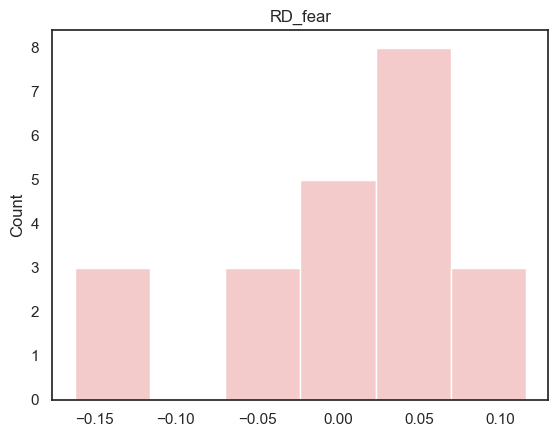

In [306]:
sns.histplot(data=RD_fear, legend = False, palette = ['#ea9999']).set_title('RD_fear')
plt.savefig(os.path.join(fpath,'Result','ISC_RD_fear.png'), dpi=300)

## Happiness

In [307]:
RD_happiness = []
for i in tqdm(group_list):
    subjects = dyad.get_group(str(i))
#     print(subjects)
    sub1 = subjects.iloc[0,0]
    sub2 = subjects.iloc[1,0]
#     print(sub1)
#     print(sub2)
    emotion_tseries_list = []
    emotion_tseries1 = pd.read_csv('/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/'+sub1+'.csv').drop("Unnamed: 0",axis=1)
    emotion_tseries2 = pd.read_csv('/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/'+sub2+'.csv').drop("Unnamed: 0",axis=1)
    emotion_tseries_list.append(emotion_tseries1)
    emotion_tseries_list.append(emotion_tseries2)
    df = pd.DataFrame()
    for j in range(len(emotion_tseries_list)):
         df = df.append(emotion_tseries_list[j]['happiness'])
#     print(df)
    isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
    RD_happiness.append(isc)
RD_happiness = pd.DataFrame(RD_happiness)

  0%|          | 0/22 [00:00<?, ?it/s]<ipython-input-307-85fe294ea3ef>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['happiness'])
<ipython-input-307-85fe294ea3ef>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['happiness'])
<ipython-input-307-85fe294ea3ef>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['happiness'])
<ipython-input-307-85fe294ea3ef>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['happiness'])
<ipython-input-307-85fe294ea3ef>:16: FutureWarning: The frame.

<ipython-input-307-85fe294ea3ef>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['happiness'])
<ipython-input-307-85fe294ea3ef>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['happiness'])
 91%|█████████ | 20/22 [00:00<00:00, 97.47it/s]<ipython-input-307-85fe294ea3ef>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['happiness'])
<ipython-input-307-85fe294ea3ef>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['happiness'])
<ipython-input-307-85fe294ea3ef>:16: FutureWarning: T

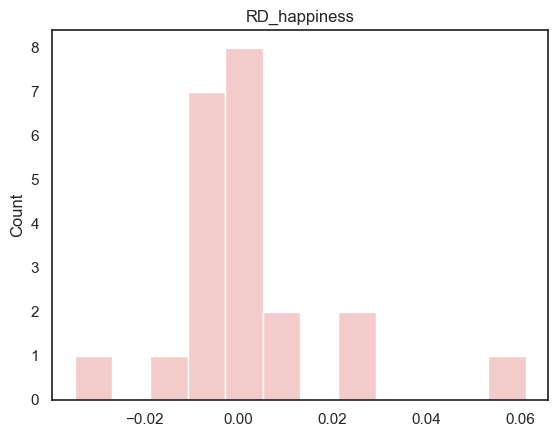

In [308]:
sns.histplot(data=RD_happiness, legend = False, palette = ['#ea9999']).set_title('RD_happiness')
plt.savefig(os.path.join(fpath,'Result','ISC_RD_happiness.png'), dpi=300)

## Sadness

In [309]:
RD_sadness = []
for i in tqdm(group_list):
    subjects = dyad.get_group(str(i))
#     print(subjects)
    sub1 = subjects.iloc[0,0]
    sub2 = subjects.iloc[1,0]
#     print(sub1)
#     print(sub2)
    emotion_tseries_list = []
    emotion_tseries1 = pd.read_csv('/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/'+sub1+'.csv').drop("Unnamed: 0",axis=1)
    emotion_tseries2 = pd.read_csv('/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/'+sub2+'.csv').drop("Unnamed: 0",axis=1)
    emotion_tseries_list.append(emotion_tseries1)
    emotion_tseries_list.append(emotion_tseries2)
    df = pd.DataFrame()
    for j in range(len(emotion_tseries_list)):
         df = df.append(emotion_tseries_list[j]['sadness'])
#     print(df)
    isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
    RD_sadness.append(isc)
RD_sadness = pd.DataFrame(RD_sadness)

  0%|          | 0/22 [00:00<?, ?it/s]<ipython-input-309-8059942d1c66>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['sadness'])
<ipython-input-309-8059942d1c66>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['sadness'])
<ipython-input-309-8059942d1c66>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['sadness'])
<ipython-input-309-8059942d1c66>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['sadness'])
<ipython-input-309-8059942d1c66>:16: FutureWarning: The frame.append m

<ipython-input-309-8059942d1c66>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['sadness'])
<ipython-input-309-8059942d1c66>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['sadness'])
 91%|█████████ | 20/22 [00:00<00:00, 96.81it/s]<ipython-input-309-8059942d1c66>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['sadness'])
<ipython-input-309-8059942d1c66>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['sadness'])
<ipython-input-309-8059942d1c66>:16: FutureWarning: The frame

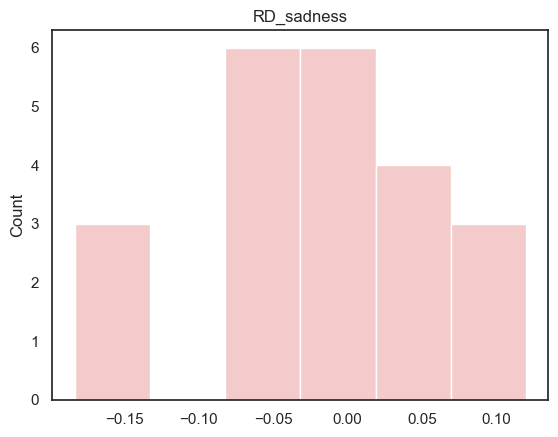

In [310]:
sns.histplot(data=RD_sadness, legend = False, palette = ['#ea9999']).set_title('RD_sadness')
plt.savefig(os.path.join(fpath,'Result','ISC_RD_sadness.png'), dpi=300)

## Surprise

In [311]:
RD_surprise = []
for i in tqdm(group_list):
    subjects = dyad.get_group(str(i))
#     print(subjects)
    sub1 = subjects.iloc[0,0]
    sub2 = subjects.iloc[1,0]
#     print(sub1)
#     print(sub2)
    emotion_tseries_list = []
    emotion_tseries1 = pd.read_csv('/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/'+sub1+'.csv').drop("Unnamed: 0",axis=1)
    emotion_tseries2 = pd.read_csv('/Users/chenyuchieh/Desktop/SED_facial/Data/SED/emotion_interpo_fps1/'+sub2+'.csv').drop("Unnamed: 0",axis=1)
    emotion_tseries_list.append(emotion_tseries1)
    emotion_tseries_list.append(emotion_tseries2)
    df = pd.DataFrame()
    for j in range(len(emotion_tseries_list)):
         df = df.append(emotion_tseries_list[j]['surprise'])
#     print(df)
    isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
    RD_surprise.append(isc)
RD_surprise = pd.DataFrame(RD_surprise)

  0%|          | 0/22 [00:00<?, ?it/s]<ipython-input-311-8e722e97514e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['surprise'])
<ipython-input-311-8e722e97514e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['surprise'])
<ipython-input-311-8e722e97514e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['surprise'])
<ipython-input-311-8e722e97514e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['surprise'])
<ipython-input-311-8e722e97514e>:16: FutureWarning: The frame.appe

<ipython-input-311-8e722e97514e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['surprise'])
<ipython-input-311-8e722e97514e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['surprise'])
 91%|█████████ | 20/22 [00:00<00:00, 97.49it/s]<ipython-input-311-8e722e97514e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['surprise'])
<ipython-input-311-8e722e97514e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(emotion_tseries_list[j]['surprise'])
<ipython-input-311-8e722e97514e>:16: FutureWarning: The f

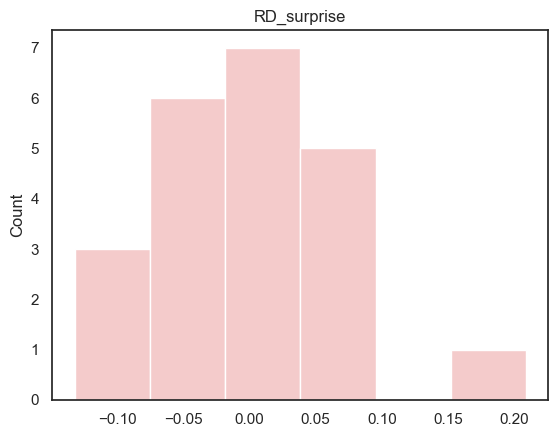

In [312]:
sns.histplot(data=RD_surprise, legend = False, palette = ['#ea9999']).set_title('RD_surprise')
plt.savefig(os.path.join(fpath,'Result','ISC_RD_surprise.png'), dpi=300)

# Pseudo Dyad (PD) ISC

## Anger

In [313]:
emotion_tseries_list = []

for sub in tqdm(sub_paths):
    sub_id = sub.split('/')[-1].split('_')[0].split('.')[0]
    if sub_id in sub_list:
        emotion_tseries = pd.read_csv(sub)['anger']
#         print(sub_id)
#         print(emotion_tseries)
        emotion_tseries_list.append(emotion_tseries)

100%|██████████| 50/50 [00:00<00:00, 262.28it/s]


In [314]:
df = emotion_tseries_list
PD_anger = []

isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
PD_anger.append(isc)

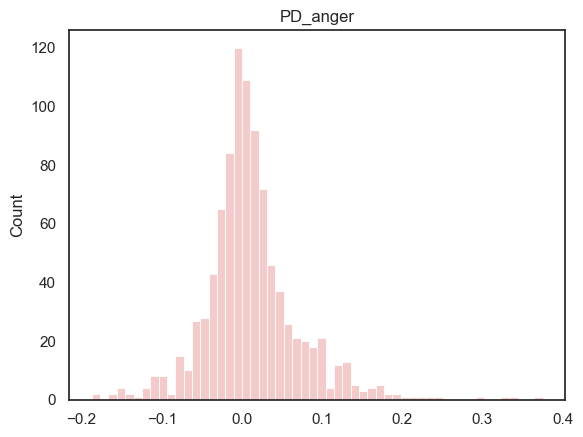

In [315]:
sns.histplot(data=PD_anger, legend = False, palette = ['#ea9999']).set_title('PD_anger')
plt.savefig(os.path.join(fpath,'Result','ISC_PD_anger.png'), dpi=300)

## Disgust

In [316]:
emotion_tseries_list = []

for sub in tqdm(sub_paths):
    sub_id = sub.split('/')[-1].split('_')[0].split('.')[0]
    if sub_id in sub_list:
        emotion_tseries = pd.read_csv(sub)['disgust']
#         print(sub_id)
#         print(emotion_tseries)
        emotion_tseries_list.append(emotion_tseries)

100%|██████████| 50/50 [00:00<00:00, 275.03it/s]


In [317]:
df = emotion_tseries_list
PD_disgust = []

isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
PD_disgust.append(isc)

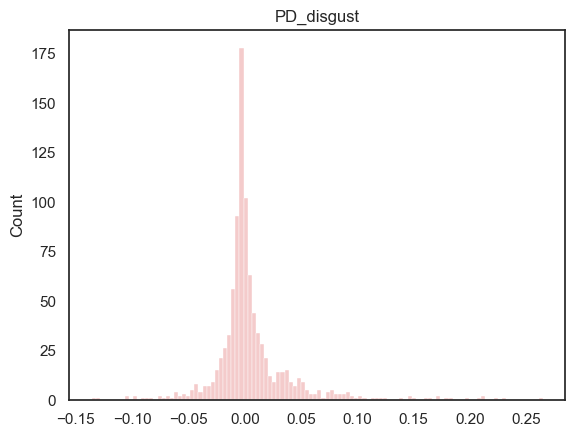

In [318]:
sns.histplot(data=PD_disgust, legend = False, palette = ['#ea9999']).set_title('PD_disgust')
plt.savefig(os.path.join(fpath,'Result','ISC_PD_disgust.png'), dpi=300)

## Fear

In [319]:
emotion_tseries_list = []

for sub in tqdm(sub_paths):
    sub_id = sub.split('/')[-1].split('_')[0].split('.')[0]
    if sub_id in sub_list:
        emotion_tseries = pd.read_csv(sub)['fear']
#         print(sub_id)
#         print(emotion_tseries)
        emotion_tseries_list.append(emotion_tseries)

100%|██████████| 50/50 [00:00<00:00, 281.85it/s]


In [320]:
df = emotion_tseries_list
PD_fear = []

isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
PD_fear.append(isc)

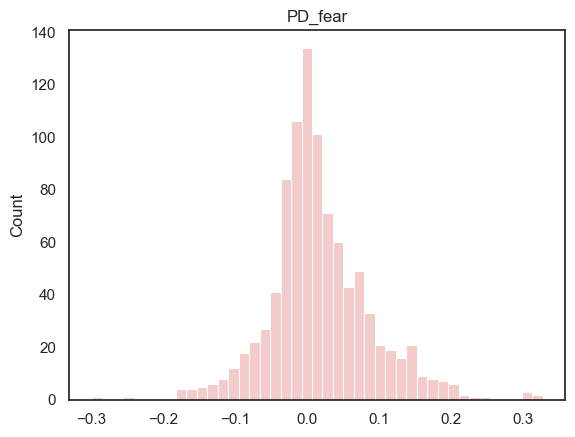

In [321]:
sns.histplot(data=PD_fear, legend = False, palette = ['#ea9999']).set_title('PD_fear')
plt.savefig(os.path.join(fpath,'Result','ISC_PD_fear.png'), dpi=300)

## Happiness

In [322]:
emotion_tseries_list = []

for sub in tqdm(sub_paths):
    sub_id = sub.split('/')[-1].split('_')[0].split('.')[0]
    if sub_id in sub_list:
        emotion_tseries = pd.read_csv(sub)['happiness']
#         print(sub_id)
#         print(emotion_tseries)
        emotion_tseries_list.append(emotion_tseries)

100%|██████████| 50/50 [00:00<00:00, 273.50it/s]


In [323]:
df = emotion_tseries_list
PD_happiness = []

isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
PD_happiness.append(isc)

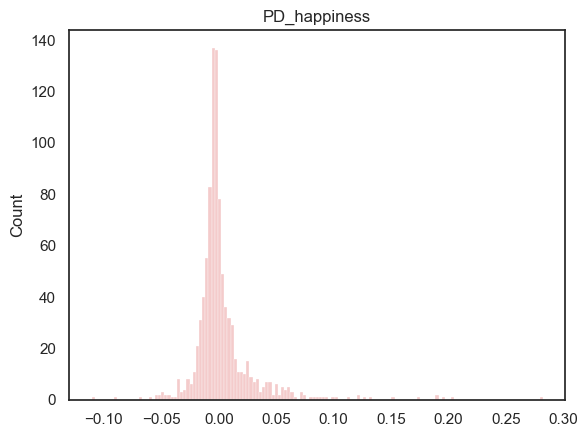

In [324]:
sns.histplot(data=PD_happiness, legend = False, palette = ['#ea9999']).set_title('PD_happiness')
plt.savefig(os.path.join(fpath,'Result','ISC_PD_happiness.png'), dpi=300)

## Sadness

In [325]:
emotion_tseries_list = []

for sub in tqdm(sub_paths):
    sub_id = sub.split('/')[-1].split('_')[0].split('.')[0]
    if sub_id in sub_list:
        emotion_tseries = pd.read_csv(sub)['sadness']
#         print(sub_id)
#         print(emotion_tseries)
        emotion_tseries_list.append(emotion_tseries)

100%|██████████| 50/50 [00:00<00:00, 281.98it/s]


In [326]:
df = emotion_tseries_list
PD_sadness = []

isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
PD_sadness.append(isc)

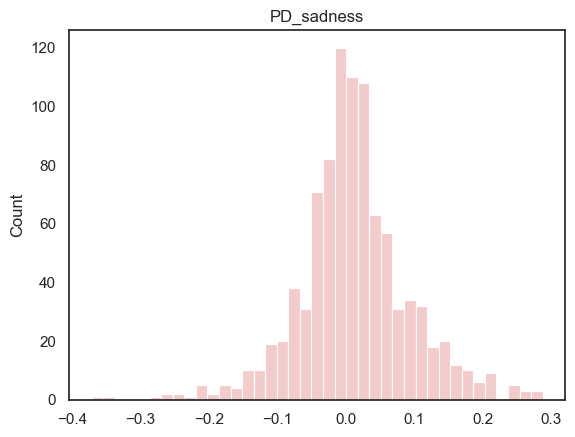

In [327]:
sns.histplot(data=PD_sadness, legend = False, palette = ['#ea9999']).set_title('PD_sadness')
plt.savefig(os.path.join(fpath,'Result','ISC_PD_sadness.png'), dpi=300)

## Surprise

In [328]:
emotion_tseries_list = []

for sub in tqdm(sub_paths):
    sub_id = sub.split('/')[-1].split('_')[0].split('.')[0]
    if sub_id in sub_list:
        emotion_tseries = pd.read_csv(sub)['surprise']
#         print(sub_id)
#         print(emotion_tseries)
        emotion_tseries_list.append(emotion_tseries)

100%|██████████| 50/50 [00:00<00:00, 281.32it/s]


In [329]:
df = emotion_tseries_list
PD_surprise = []

isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
PD_surprise.append(isc)

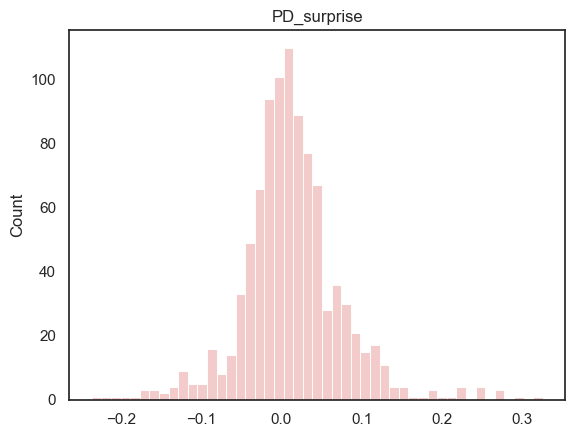

In [330]:
sns.histplot(data=PD_surprise, legend = False, palette = ['#ea9999']).set_title('PD_surprise')
plt.savefig(os.path.join(fpath,'Result','ISC_PD_surprise.png'), dpi=300)

# Alone (A) ISC

In [331]:
alone = pd.read_csv((os.path.join(fpath, 'Data', 'SES', 'SES_subject list.csv')))
# Drop the subject without facial data
alone.drop(alone.index[alone['facial'] == 'N'], inplace=True)
alone.drop(alone.index[alone['pre_att_dyads'] == 'against'], inplace=True)
alone.drop(alone.index[alone['pre_att_dyads'] == 'useless'], inplace=True)
alone.drop("Unnamed: 0",axis=1)
# len(alone)

,ID,pre_att,post_att,pre_att_dyads,facial
1,SES002,76,76,support,Y
8,SES009,80,57,support,Y
9,SES010,70,83,support,Y
10,SES011,69,67,support,Y
12,SES013,72,54,support,Y
13,SES014,75,68,support,Y
15,SES016,85,87,support,Y
16,SES017,78,44,support,Y
23,SES024,86,94,support,Y
24,SES025,70,72,support,Y


In [332]:
sub_paths = sorted(glob.glob(os.path.join(fpath, 'Data','SES', 'emotion_interpo_fps1', '*.csv')))
sub_paths

['/Users/chenyuchieh/Desktop/SED_facial/Data/SES/emotion_interpo_fps1/SES001.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SES/emotion_interpo_fps1/SES002.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SES/emotion_interpo_fps1/SES004.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SES/emotion_interpo_fps1/SES005.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SES/emotion_interpo_fps1/SES006.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SES/emotion_interpo_fps1/SES007.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SES/emotion_interpo_fps1/SES008.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SES/emotion_interpo_fps1/SES009.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SES/emotion_interpo_fps1/SES010.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SES/emotion_interpo_fps1/SES011.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SES/emotion_interpo_fps1/SES012.csv',
 '/Users/chenyuchieh/Desktop/SED_facial/Data/SES/emotion_interpo_fps1/SES013.csv',
 '/U

In [333]:
sub_list = []
for sub in sub_paths:
    sub_id = sub.split('/')[-1].split('.')[0]
    if sub_id in list(alone['ID']):
#         print(sub_id)
        sub_list.append(sub_id)
sub_list

['SES002',
 'SES009',
 'SES010',
 'SES011',
 'SES013',
 'SES014',
 'SES016',
 'SES017',
 'SES024',
 'SES025',
 'SES026',
 'SES031',
 'SES037',
 'SES043',
 'SES044',
 'SES046',
 'SES047',
 'SES049',
 'SES050',
 'SES051',
 'SES053']

## Anger

In [334]:
emotion_tseries_list = []

for sub in tqdm(sub_paths):
    sub_id = sub.split('/')[-1].split('_')[0].split('.')[0]
    if sub_id in sub_list:
        emotion_tseries = pd.read_csv(sub)['anger']
#         print(sub_id)
#         print(emotion_tseries)
        emotion_tseries_list.append(emotion_tseries)

100%|██████████| 48/48 [00:00<00:00, 458.69it/s]


In [335]:
df = emotion_tseries_list
A_anger = []

isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
A_anger.append(isc)

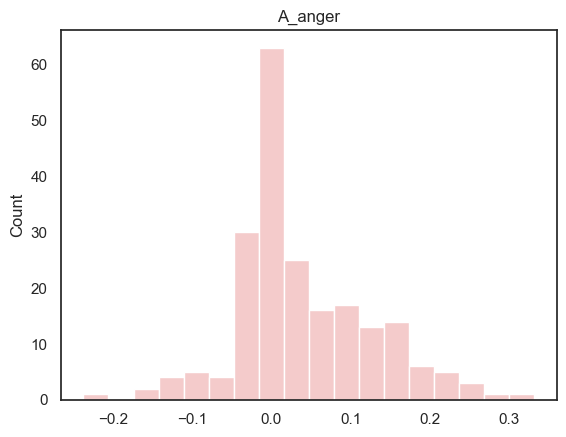

In [336]:
sns.histplot(data=A_anger, legend = False, palette = ['#ea9999']).set_title('A_anger')
plt.savefig(os.path.join(fpath,'Result','ISC_A_anger.png'), dpi=300)

## Disgust

In [337]:
emotion_tseries_list = []

for sub in tqdm(sub_paths):
    sub_id = sub.split('/')[-1].split('_')[0].split('.')[0]
    if sub_id in sub_list:
        emotion_tseries = pd.read_csv(sub)['disgust']
#         print(sub_id)
#         print(emotion_tseries)
        emotion_tseries_list.append(emotion_tseries)

100%|██████████| 48/48 [00:00<00:00, 565.65it/s]


In [338]:
df = emotion_tseries_list
A_disgust = []

isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
A_disgust.append(isc)

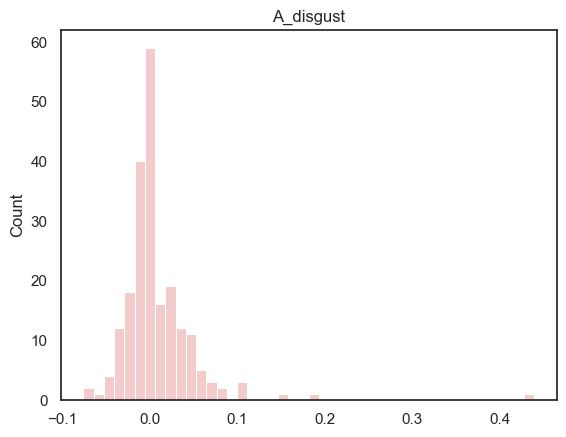

In [339]:
sns.histplot(data=A_disgust, legend = False, palette = ['#ea9999']).set_title('A_disgust')
plt.savefig(os.path.join(fpath,'Result','ISC_A_disgust.png'), dpi=300)

## Fear

In [340]:
emotion_tseries_list = []

for sub in tqdm(sub_paths):
    sub_id = sub.split('/')[-1].split('_')[0].split('.')[0]
    if sub_id in sub_list:
        emotion_tseries = pd.read_csv(sub)['fear']
#         print(sub_id)
#         print(emotion_tseries)
        emotion_tseries_list.append(emotion_tseries)

100%|██████████| 48/48 [00:00<00:00, 566.14it/s]


In [341]:
df = emotion_tseries_list
A_fear = []

isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
A_fear.append(isc)

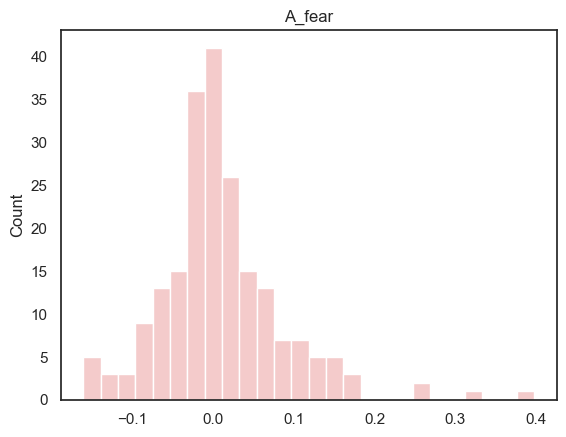

In [342]:
sns.histplot(data=A_fear, legend = False, palette = ['#ea9999']).set_title('A_fear')
plt.savefig(os.path.join(fpath,'Result','ISC_A_fear.png'), dpi=300)

## Happiness

In [343]:
emotion_tseries_list = []

for sub in tqdm(sub_paths):
    sub_id = sub.split('/')[-1].split('_')[0].split('.')[0]
    if sub_id in sub_list:
        emotion_tseries = pd.read_csv(sub)['happiness']
#         print(sub_id)
#         print(emotion_tseries)
        emotion_tseries_list.append(emotion_tseries)

100%|██████████| 48/48 [00:00<00:00, 567.90it/s]


In [344]:
df = emotion_tseries_list
A_happiness = []

isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
A_happiness.append(isc)

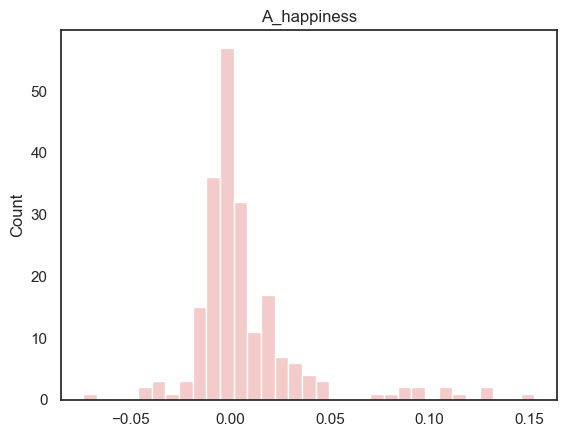

In [345]:
sns.histplot(data=A_happiness, legend = False, palette = ['#ea9999']).set_title('A_happiness')
plt.savefig(os.path.join(fpath,'Result','ISC_A_happiness.png'), dpi=300)

## Sadness

In [346]:
emotion_tseries_list = []

for sub in tqdm(sub_paths):
    sub_id = sub.split('/')[-1].split('_')[0].split('.')[0]
    if sub_id in sub_list:
        emotion_tseries = pd.read_csv(sub)['sadness']
#         print(sub_id)
#         print(emotion_tseries)
        emotion_tseries_list.append(emotion_tseries)

100%|██████████| 48/48 [00:00<00:00, 561.13it/s]


In [347]:
df = emotion_tseries_list
A_sadness = []

isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
A_sadness.append(isc)

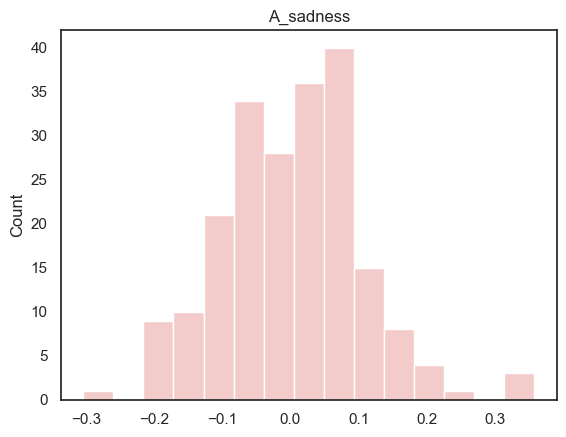

In [348]:
sns.histplot(data=A_sadness, legend = False, palette = ['#ea9999']).set_title('A_sadness')
plt.savefig(os.path.join(fpath,'Result','ISC_A_sadness.png'), dpi=300)

## Surprise

In [349]:
emotion_tseries_list = []

for sub in tqdm(sub_paths):
    sub_id = sub.split('/')[-1].split('_')[0].split('.')[0]
    if sub_id in sub_list:
        emotion_tseries = pd.read_csv(sub)['surprise']
#         print(sub_id)
#         print(emotion_tseries)
        emotion_tseries_list.append(emotion_tseries)

100%|██████████| 48/48 [00:00<00:00, 571.69it/s]


In [350]:
df = emotion_tseries_list
A_surprise = []

isc = 1 - spatial.distance.pdist(df, metric = 'correlation')
A_surprise.append(isc)

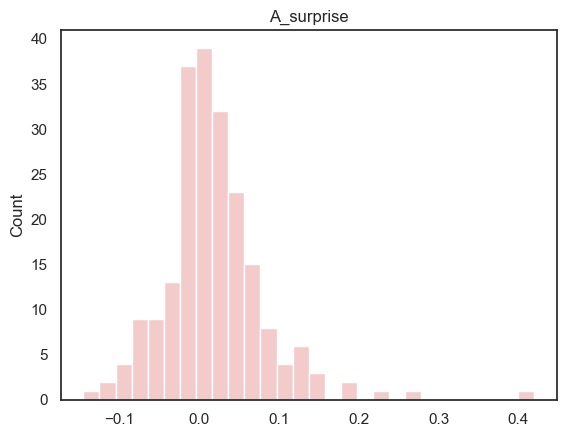

In [253]:
sns.histplot(data=A_surprise, legend = False, palette = ['#ea9999']).set_title('A_surprise')
plt.savefig(os.path.join(fpath,'Result','ISC_A_surprise.png'), dpi=300)

# Visualization

* 假設：RD > PD > A（藍色>綠色>橘色）

## Anger

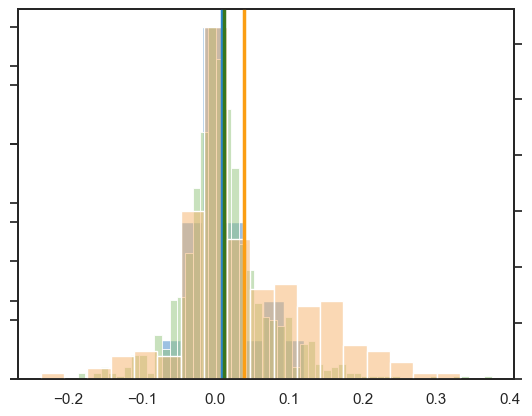

In [420]:
# RD:藍色; PD:綠色; A: 橘色
ax1 = sns.histplot(data=RD_anger, legend = False, palette = ['#3d85c6'])
ax2 = ax1.twinx()
ax2 = sns.histplot(data=PD_anger, legend = False, palette = ['#93c47d'])
ax3 = ax2.twinx()
ax3 = sns.histplot(data=A_anger, legend = False, palette = ['#f6b26b'])
ax1.set(ylabel=None, yticklabels=[])
ax2.set(ylabel=None, yticklabels=[])
ax3.set(ylabel=None, yticklabels=[])
plt.axvline(x=RD_anger.mean()[0], color='#2986cc', lw=2.5)
plt.axvline(x=np.mean(PD_anger), color='#38761d', lw=2.5)
plt.axvline(x=np.mean(A_anger), color='#fb9e14', lw=2.5)

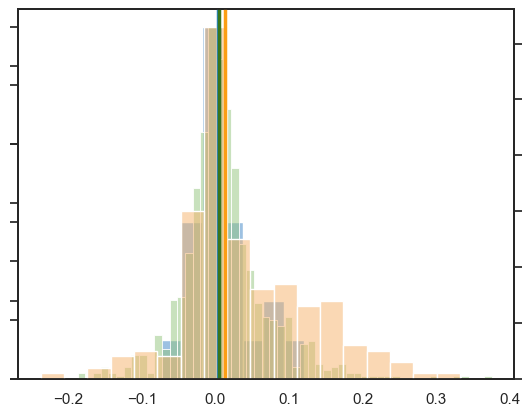

In [421]:
# RD:藍色; PD:綠色; A: 橘色
ax1 = sns.histplot(data=RD_anger, legend = False, palette = ['#3d85c6'])
ax2 = ax1.twinx()
ax2 = sns.histplot(data=PD_anger, legend = False, palette = ['#93c47d'])
ax3 = ax2.twinx()
ax3 = sns.histplot(data=A_anger, legend = False, palette = ['#f6b26b'])
ax1.set(ylabel=None, yticklabels=[])
ax2.set(ylabel=None, yticklabels=[])
ax3.set(ylabel=None, yticklabels=[])
plt.axvline(x=RD_anger.median()[0], color='#2986cc', lw=2.5)
plt.axvline(x=np.median(PD_anger), color='#38761d', lw=2.5)
plt.axvline(x=np.median(A_anger), color='#fb9e14', lw=2.5)

## Disgust

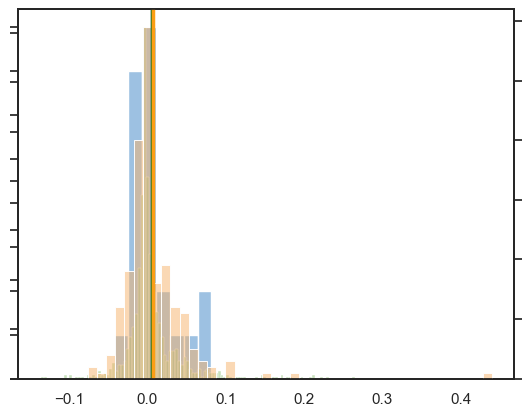

In [422]:
# RD:藍色; PD:綠色; A: 橘色
ax1 = sns.histplot(data=RD_disgust, legend = False, palette = ['#3d85c6'])
ax2 = ax1.twinx()
ax2 = sns.histplot(data=PD_disgust, legend = False, palette = ['#93c47d'])
ax3 = ax2.twinx()
ax3 = sns.histplot(data=A_disgust, legend = False, palette = ['#f6b26b'])
ax1.set(ylabel=None, yticklabels=[])
ax2.set(ylabel=None, yticklabels=[])
ax3.set(ylabel=None, yticklabels=[])
plt.axvline(x=RD_disgust.mean()[0], color='#2986cc', lw=2.5)
plt.axvline(x=np.mean(PD_disgust), color='#38761d', lw=2.5)
plt.axvline(x=np.mean(A_disgust), color='#fb9e14', lw=2.5)

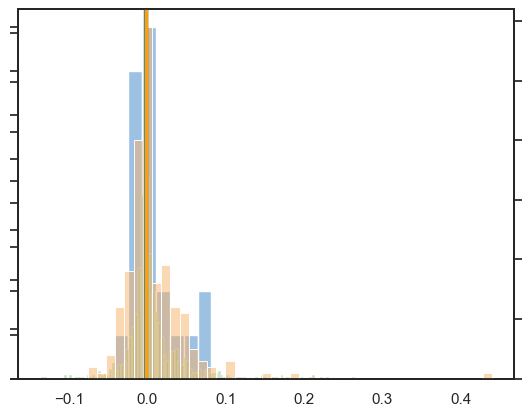

In [423]:
# RD:藍色; PD:綠色; A: 橘色
ax1 = sns.histplot(data=RD_disgust, legend = False, palette = ['#3d85c6'])
ax2 = ax1.twinx()
ax2 = sns.histplot(data=PD_disgust, legend = False, palette = ['#93c47d'])
ax3 = ax2.twinx()
ax3 = sns.histplot(data=A_disgust, legend = False, palette = ['#f6b26b'])
ax1.set(ylabel=None, yticklabels=[])
ax2.set(ylabel=None, yticklabels=[])
ax3.set(ylabel=None, yticklabels=[])
plt.axvline(x=RD_disgust.median()[0], color='#2986cc', lw=2.5)
plt.axvline(x=np.median(PD_disgust), color='#38761d', lw=2.5)
plt.axvline(x=np.median(A_disgust), color='#fb9e14', lw=2.5)

## Fear

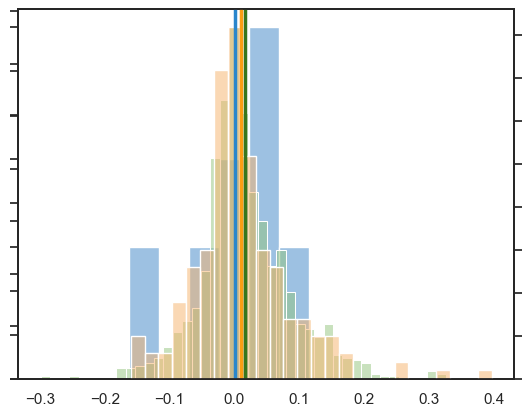

In [425]:
# RD:藍色; PD:綠色; A: 橘色
ax1 = sns.histplot(data=RD_fear, legend = False, palette = ['#3d85c6'])
ax2 = ax1.twinx()
ax2 = sns.histplot(data=PD_fear, legend = False, palette = ['#93c47d'])
ax3 = ax2.twinx()
ax3 = sns.histplot(data=A_fear, legend = False, palette = ['#f6b26b'])
ax1.set(ylabel=None, yticklabels=[])
ax2.set(ylabel=None, yticklabels=[])
ax3.set(ylabel=None, yticklabels=[])
plt.axvline(x=RD_fear.mean()[0], color='#2986cc', lw=2.5)
plt.axvline(x=np.mean(PD_fear), color='#38761d', lw=2.5)
plt.axvline(x=np.mean(A_fear), color='#fb9e14', lw=2.5)

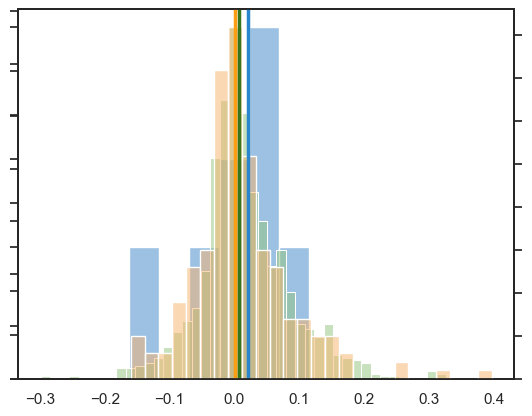

In [426]:
# RD:藍色; PD:綠色; A: 橘色
ax1 = sns.histplot(data=RD_fear, legend = False, palette = ['#3d85c6'])
ax2 = ax1.twinx()
ax2 = sns.histplot(data=PD_fear, legend = False, palette = ['#93c47d'])
ax3 = ax2.twinx()
ax3 = sns.histplot(data=A_fear, legend = False, palette = ['#f6b26b'])
ax1.set(ylabel=None, yticklabels=[])
ax2.set(ylabel=None, yticklabels=[])
ax3.set(ylabel=None, yticklabels=[])
plt.axvline(x=RD_fear.median()[0], color='#2986cc', lw=2.5)
plt.axvline(x=np.median(PD_fear), color='#38761d', lw=2.5)
plt.axvline(x=np.median(A_fear), color='#fb9e14', lw=2.5)

## Happiness

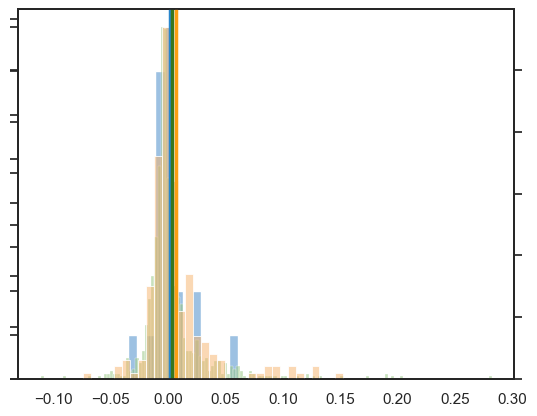

In [427]:
# RD:藍色; PD:綠色; A: 橘色
ax1 = sns.histplot(data=RD_happiness, legend = False, palette = ['#3d85c6'])
ax2 = ax1.twinx()
ax2 = sns.histplot(data=PD_happiness, legend = False, palette = ['#93c47d'])
ax3 = ax2.twinx()
ax3 = sns.histplot(data=A_happiness, legend = False, palette = ['#f6b26b'])
ax1.set(ylabel=None, yticklabels=[])
ax2.set(ylabel=None, yticklabels=[])
ax3.set(ylabel=None, yticklabels=[])
plt.axvline(x=RD_happiness.mean()[0], color='#2986cc', lw=2.5)
plt.axvline(x=np.mean(PD_happiness), color='#38761d', lw=2.5)
plt.axvline(x=np.mean(A_happiness), color='#fb9e14', lw=2.5)

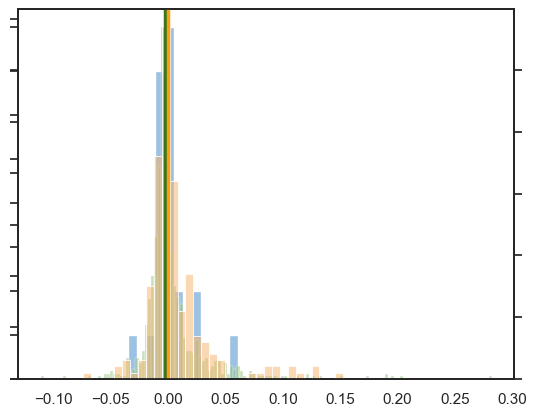

In [428]:
# RD:藍色; PD:綠色; A: 橘色
ax1 = sns.histplot(data=RD_happiness, legend = False, palette = ['#3d85c6'])
ax2 = ax1.twinx()
ax2 = sns.histplot(data=PD_happiness, legend = False, palette = ['#93c47d'])
ax3 = ax2.twinx()
ax3 = sns.histplot(data=A_happiness, legend = False, palette = ['#f6b26b'])
ax1.set(ylabel=None, yticklabels=[])
ax2.set(ylabel=None, yticklabels=[])
ax3.set(ylabel=None, yticklabels=[])
plt.axvline(x=RD_happiness.median()[0], color='#2986cc', lw=2.5)
plt.axvline(x=np.median(PD_happiness), color='#38761d', lw=2.5)
plt.axvline(x=np.median(A_happiness), color='#fb9e14', lw=2.5)

## Sadness

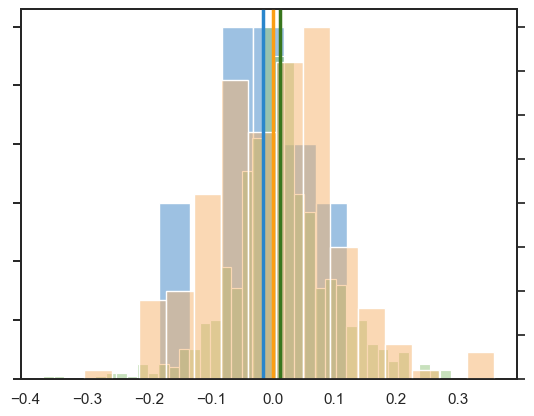

In [418]:
# RD:藍色; PD:綠色; A: 橘色
ax1 = sns.histplot(data=RD_sadness, legend = False, palette = ['#3d85c6'])
ax2 = ax1.twinx()
ax2 = sns.histplot(data=PD_sadness, legend = False, palette = ['#93c47d'])
ax3 = ax2.twinx()
ax3 = sns.histplot(data=A_sadness, legend = False, palette = ['#f6b26b'])
ax1.set(ylabel=None, yticklabels=[])
ax2.set(ylabel=None, yticklabels=[])
ax3.set(ylabel=None, yticklabels=[])
plt.axvline(x=RD_sadness.mean()[0], color='#2986cc', lw=2.5)
plt.axvline(x=np.mean(PD_sadness), color='#38761d', lw=2.5)
plt.axvline(x=np.mean(A_sadness), color='#fb9e14', lw=2.5)

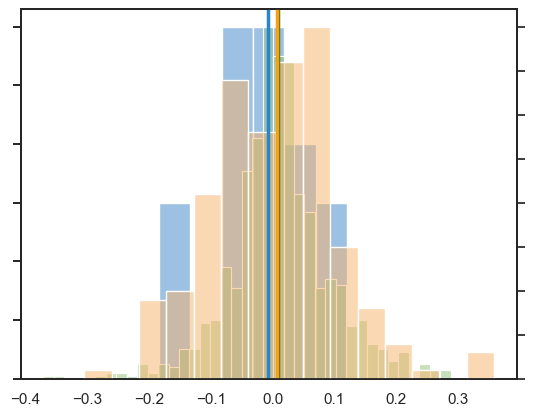

In [419]:
# RD:藍色; PD:綠色; A: 橘色
ax1 = sns.histplot(data=RD_sadness, legend = False, palette = ['#3d85c6'])
ax2 = ax1.twinx()
ax2 = sns.histplot(data=PD_sadness, legend = False, palette = ['#93c47d'])
ax3 = ax2.twinx()
ax3 = sns.histplot(data=A_sadness, legend = False, palette = ['#f6b26b'])
ax1.set(ylabel=None, yticklabels=[])
ax2.set(ylabel=None, yticklabels=[])
ax3.set(ylabel=None, yticklabels=[])
plt.axvline(x=RD_sadness.median()[0], color='#2986cc', lw=2.5)
plt.axvline(x=np.median(PD_sadness), color='#38761d', lw=2.5)
plt.axvline(x=np.median(A_sadness), color='#fb9e14', lw=2.5)

## Surprise

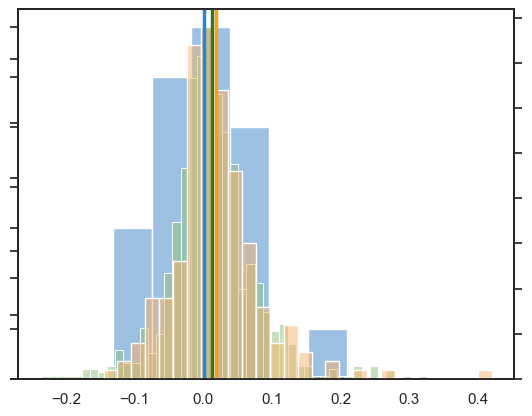

In [416]:
# RD:藍色; PD:綠色; A: 橘色
ax1 = sns.histplot(data=RD_surprise, legend = False, palette = ['#3d85c6'])
ax2 = ax1.twinx()
ax2 = sns.histplot(data=PD_surprise, legend = False, palette = ['#93c47d'])
ax3 = ax2.twinx()
ax3 = sns.histplot(data=A_surprise, legend = False, palette = ['#f6b26b'])
ax1.set(ylabel=None, yticklabels=[])
ax2.set(ylabel=None, yticklabels=[])
ax3.set(ylabel=None, yticklabels=[])
plt.axvline(x=RD_surprise.mean()[0], color='#2986cc', lw=2.5)
plt.axvline(x=np.mean(PD_surprise), color='#38761d', lw=2.5)
plt.axvline(x=np.mean(A_surprise), color='#fb9e14', lw=2.5)

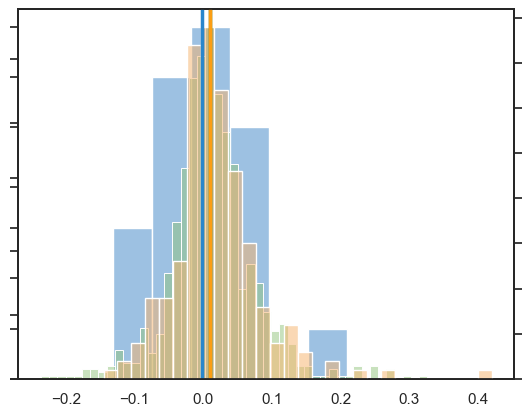

In [417]:
# RD:藍色; PD:綠色; A: 橘色
ax1 = sns.histplot(data=RD_surprise, legend = False, palette = ['#3d85c6'])
ax2 = ax1.twinx()
ax2 = sns.histplot(data=PD_surprise, legend = False, palette = ['#93c47d'])
ax3 = ax2.twinx()
ax3 = sns.histplot(data=A_surprise, legend = False, palette = ['#f6b26b'])
ax1.set(ylabel=None, yticklabels=[])
ax2.set(ylabel=None, yticklabels=[])
ax3.set(ylabel=None, yticklabels=[])
plt.axvline(x=RD_surprise.median()[0], color='#2986cc', lw=2.5)
plt.axvline(x=np.median(PD_surprise), color='#38761d', lw=2.5)
plt.axvline(x=np.median(A_surprise), color='#fb9e14', lw=2.5)